# Model Predictive Control for DED using GAMMA, Pytorch Implementation
created on 5/22/2024

In [1]:
# Import all the packages we need
import numpy as np
import cupy as cp
cp.cuda.Device(0).use()
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# from scipy.optimize import minimize, Bounds

# For TiDE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(3)
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F

import os
import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# import functions
from TiDE import TideModule, quantile_loss, TiDE_forward

from RobustMPC_pytorch import RMPC
from nn_functions import surrogate
from torchmin import minimize as pytorch_minimize
from scipy.optimize import minimize, Bounds

from moving_average import moving_average_1d
import copy

from GAMMA_obj_temp_depth import GAMMA_obj
from obj_fun_depth import RMPC_obj_wo_constraint, RMPC_obj_wo_constraint_scipy
from GAMMA_MPC_temp_depth import GAMMA_MPC
from utils import sigmoid, LossParameters, GlobalState


/home/ycv5080/miniconda3/envs/GAMMA_TiDE/lib/python3.10/site-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


cuda is available


### Load pre-trained model

In [2]:
# with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0826.pkl', 'rb') as file:
# with open('TiDE_params_single_track_square_MV_lp_temp_depth_less_cov.pkl', 'rb') as file:
# _less_cov_0828_w50_p50_ok.pkl', 'rb') as file: # This one is ok, but have a peak at layer 9
# with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0830_w50_p50_2.pkl', 'rb') as file: # not good, but might work
# with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0830_w50_p50.pkl', 'rb') as file: # works but with small spikes
# with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0901_w50_p50.pkl', 'rb') as file: # not applicable at all
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file: # currently using this one
# with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0903_w50_p50.pkl', 'rb') as file: # not practical


   
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
P = 50
window = 50

In [3]:
total_params = sum(p.numel() for p in nominal_TiDE.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 796594


### Build class for ML surrogate

In [4]:
'''
inputs:
    nominal_param: nominal parameters saved from nominal_preparation
    nominal_NN   : a complete nn.module model with the pretrained parameters are loaded
'''
TiDE = surrogate(nominal_params, nominal_TiDE)

### Load reference trajectory

#### Run GAMMA for initialization

In [5]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 #50 

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

100%|██████████| 250/250 [00:13<00:00, 18.37it/s]


#### Fix covariates as the configuration is given

In [6]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)
# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)
# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

# replace the reference with fixed temperature
#mp_temp_ref = torch.ones([6120],dtype=torch.float32)*3000


# # manually fix reference
# mp_temp_ref[50:65] = torch.tensor(mp_temp_raw[50:65],dtype=torch.float32)

# plt.plot(np.repeat(mp_temp_raw[0:50],5), label='raw data')
# plt.plot(np.repeat(mp_temp_ref[0:50],5), label='ref_smoothing')
# plt.plot(np.repeat(init_avg,5), label='GAMMA+avg')
# plt.plot(GAMMA_class.melt_pool_temp_save["temp"].values, label='GAMMA raw')
# plt.legend()


# replace the reference with fixed temperature
#mp_temp_ref = torch.ones([6196+50],dtype=torch.float32)*3500


In [7]:
test_tensor_1 = torch.tensor([1,2,3,4,5,6,7])
test_tensor_2 = torch.tensor([1,1,1,1,1,1,1])

indices_1 = torch.where((test_tensor_1 > 3) & (test_tensor_1 < 5))[0]

# Find indices in test_tensor_2 where elements are > 30 and < 40
indices_2 = torch.where((test_tensor_2 <2) )[0]

print("Indices in test_tensor_1:", indices_1)
print("Indices in test_tensor_2:", indices_2)

intersection = torch.tensor(np.intersect1d(indices_1, indices_2))

print("Intersection of indices_1 and indices_2:", intersection)
print(f"selected term in tensor_1 = {test_tensor_1[intersection]}")
print(f"selected term in tensor_2 = {test_tensor_2[intersection]}")

all_indices = torch.arange(test_tensor_1.size(0))
remaining_indices = all_indices[~torch.isin(all_indices,intersection)]

filtered_tensor = test_tensor_1[remaining_indices]

print(filtered_tensor)


Indices in test_tensor_1: tensor([3])
Indices in test_tensor_2: tensor([0, 1, 2, 3, 4, 5, 6])
Intersection of indices_1 and indices_2: tensor([3])
selected term in tensor_1 = tensor([4])
selected term in tensor_2 = tensor([1])
tensor([1, 2, 3, 5, 6, 7])


In [8]:
import torch
from torch.nn import ReLU
from utils import softmax_max, softmax_min

# LossParam = LossParameters(alpha0=1, delta_alpha = 5, lamda0 = 10) #This set works pretty well with torch.max, Q:R = 1:8

# LossParam = LossParameters(alpha0=1, delta_alpha = 2, lamda0 = 5) # This set works ok with sum(g2), Q:R = 1:8
# LossParam = LossParameters(alpha0=1, delta_alpha = 3, lamda0 = 10) for 0830_3 with Q:R = 1:8, torch.max, with K=-0.05, newton-exact

# LossParam = LossParameters(alpha0=1, delta_alpha = 3, lamda0 = 15)
LossParam = LossParameters(alpha0=1, delta_alpha = 3, lamda0 = 0)

relu = ReLU()
global_state = GlobalState()

def RMPC_obj_w_constraint(u_hat0:torch.tensor, # future u values within the control horizon, length = M; this should be the warm start version
                u_future_fix:torch.tensor, # future u values within the control horizon but not the design variables
                u_past:torch.tensor, # past u
                x_past_fix: torch.tensor, # past state of x, size (N,window)
                x_past:torch.tensor, # past state that changes
                SP_hat:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal # NN object we're using
):
    ''' 
    All the data that goes into this module should be normalized
    '''    
    
    u_hat = u_hat0.reshape(-1,1)
    u_hat_in = u_hat0.unsqueeze(0)
    x_hat_all = NN_Nominal.forward(u_hat, u_future_fix, u_past, x_past_fix, x_past)
    
    x_hat = x_hat_all[:,0]
    
    # compute objective value
    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    #u = u_hat_temp[0].reshape(-1,1)
    u = u_past[-1].reshape(-1,1)
    u_hat1 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u 
    
    # get the elements that is at the corner
    # x at the corner
    
    if x_past_fix[-1,0] >= -0.2:
    
        with torch.no_grad():
            # indices_1 = torch.where((u_future_fix[:,1] <= -0.95) | (u_future_fix[:,1] >= 0.95))[0]
            # indices_2 = torch.where((u_future_fix[:,2] <= -0.95) | (u_future_fix[:,2] >= 0.95))[0]
            indices_1 = torch.where((u_future_fix[:,1] <= -0.95))[0]
            indices_2 = torch.where((u_future_fix[:,2] <= -0.95))[0]
            intersection = torch.tensor(np.intersect1d(indices_1, indices_2))
            all_indices = torch.arange(u_future_fix[:,1].size(0))
            remaining_indices = all_indices[~torch.isin(all_indices,intersection)]
        
        
        # ======= using torch.min/torch.max ============
        #depth_max = torch.max(x_hat_all[:,1][remaining_indices])
        # depth_min = torch.min(x_hat_all[:,1][remaining_indices])
        
        # u_max = torch.max(u_hat0[remaining_indices])
        # u_min = torch.min(u_hat0[remaining_indices])
        
        # ======== using max ================
        # depth_max = torch.max(x_hat_all[:,1][remaining_indices].reshape(-1,1))
        # g2 = (depth_max - 0.412414)/0.412414
        # Loss_g2 = LossParam.lamda_1.item()*relu(g2) + 0.5*LossParam.alpha_1.item()*(relu(g2)**2)
        # Loss = Loss_g2 
        # LossParam.alpha_1 = np.min((LossParam.alpha_1*LossParam.delta_alpha,10000))
        # LossParam.lamda_1 = LossParam.lamda_1 + LossParam.alpha_1*relu(g2).item()
        
        # ======= look at all violation ====
        depth = x_hat_all[:,1][remaining_indices].reshape(-1,1)
        #depth = x_hat_all[:,1].reshape(-1,1)
        g2 = (depth - 0.412414)/0.412414
        Loss_g2 = LossParam.lamda_1.item()*sum(relu(g2)) + 0.5*LossParam.alpha_1.item()*(sum(relu(g2))**2)
        LossParam.lamda_1 = LossParam.lamda_1 + LossParam.alpha_1*sum(relu(g2)).item()
        LossParam.alpha_1 = np.min((LossParam.alpha_1*LossParam.delta_alpha,10000))
        Loss = Loss_g2/30
        
        
        g3 = g3 = (0.1354-depth)/0.1354
        Loss_g3 = LossParam.lamda_2.item()*sum(relu(g3)) + 0.5*LossParam.alpha_2.item()*(sum(relu(g3))**2)
        LossParam.lamda_2 = LossParam.lamda_2 + LossParam.alpha_2*sum(relu(g3)).item()
        LossParam.alpha_2 = np.min((LossParam.alpha_2*LossParam.delta_alpha,10000))
        
        if torch.any(u_future_fix[0,0]!=u_future_fix[:,0]) or torch.any(u_future_fix[0,0] != x_past_fix[:,0]):
            Loss_g3 = 0  
        
        Loss = Loss_g2/30 + Loss_g3/30
        
    else: 
        Loss = 0
    
    Obj = 1 * torch.sum((x_hat-torch.tensor(SP_hat.transpose(1,0),dtype=torch.float32))**2) + 10*torch.sum((u_hat1[:-1]-u_hat_temp)**2) 
      
        
    # Normalize objective value
    if global_state.optim_iter_count == 0 or global_state.optim_iter_count == 300:
        global_state.update_f0(Obj.item())
    
    obj_s = Obj/global_state.get_f0()  


    # relu = ReLU()
    
    # penalty = torch.sum(relu(u - torch.ones_like(u))**2) + torch.sum(relu(-torch.ones_like(u) - u)**2)
    global_state.update_optim_iter_count()
    
    
    return obj_s + Loss/global_state.get_f0()


In [9]:
def plot_fig(MPC_GAMMA, N_step):
    plt.figure(figsize=[12,10])
    plt.subplot(3,1,1)
    plt.plot(MPC_GAMMA.x_past_save[:N_step,0], label = "GAMMA simulation")
    plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,0], label="TiDE prediction")
    plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
    plt.legend()


    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.ylabel("Melt Pool Temperature (k)")

    plt.subplot(3,1,2)
    plt.plot(MPC_GAMMA.x_past_save[:N_step,1], label = "GAMMA simulation")
    plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,1], label="TiDE prediction")
    plt.plot(np.linspace(0,N_step,N_step),0.225*np.ones(N_step))
    plt.plot(np.linspace(0,N_step,N_step),0.075*np.ones(N_step))
    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.ylabel("Melt Pool Depth (mm)")
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(MPC_GAMMA.u_past_save[:N_step])
    plt.ylabel("Laser power (w)")
    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.show()


  0%|          | 0/6196 [00:00<?, ?it/s]

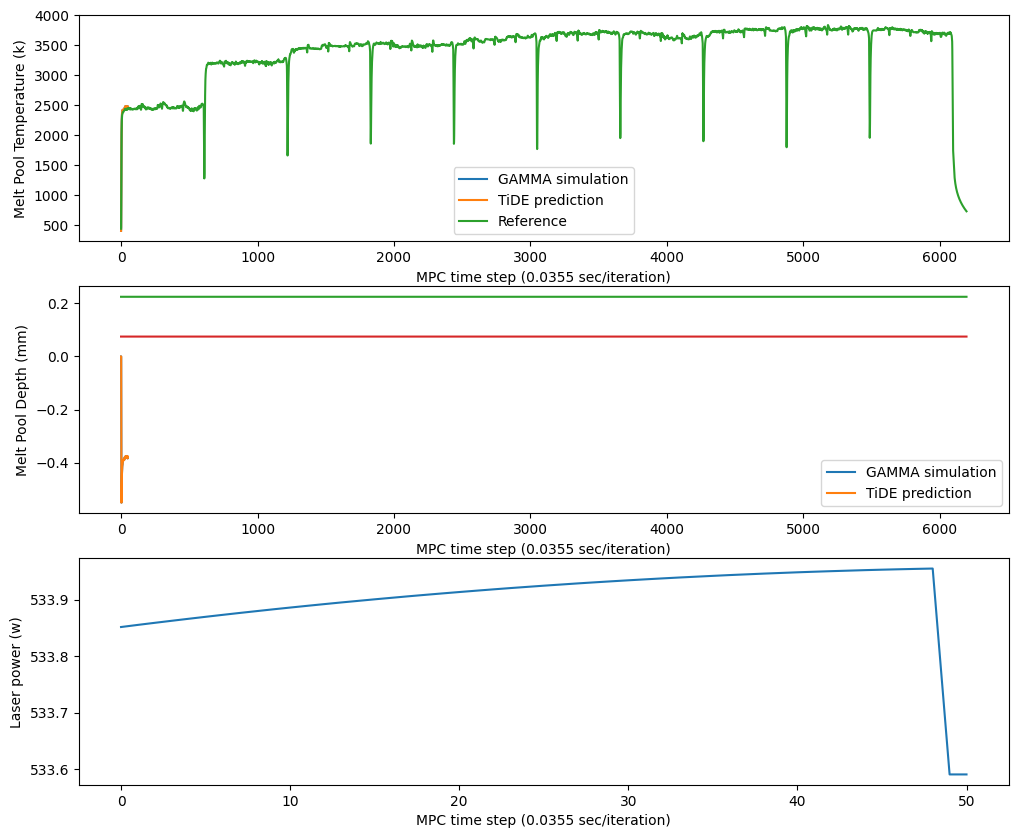

 10%|▉         | 600/6196 [04:50<40:55,  2.28it/s]  

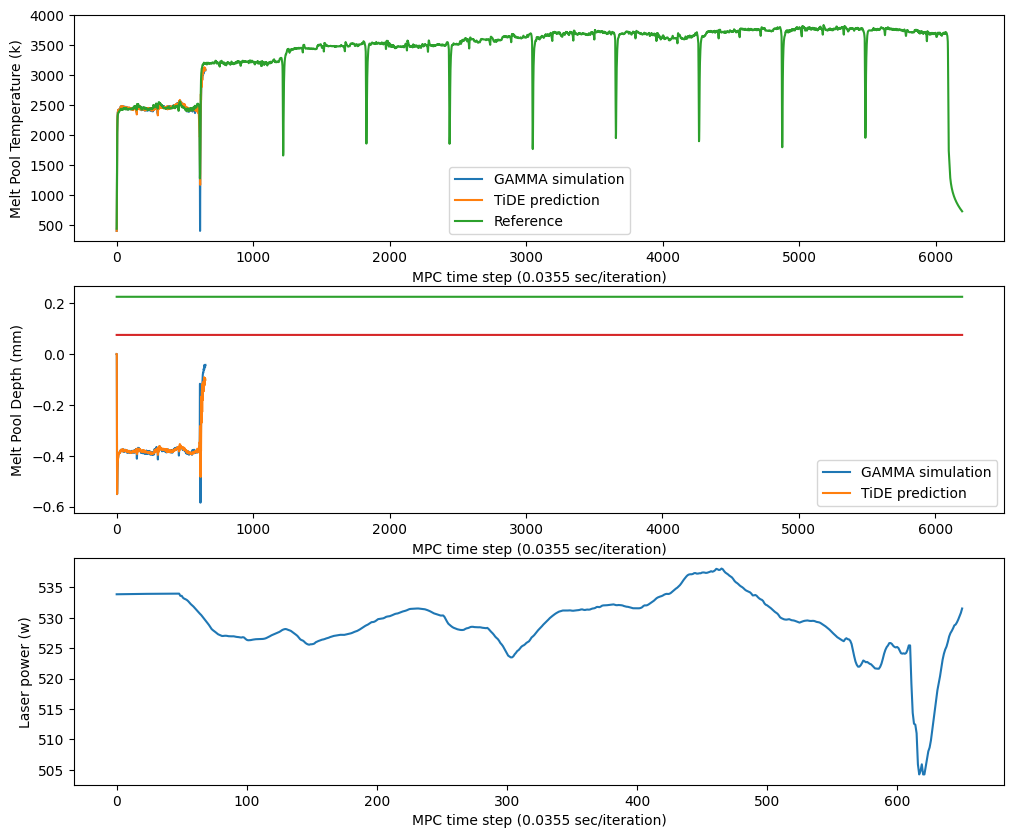

 19%|█▉        | 1200/6196 [10:08<41:20,  2.01it/s]  

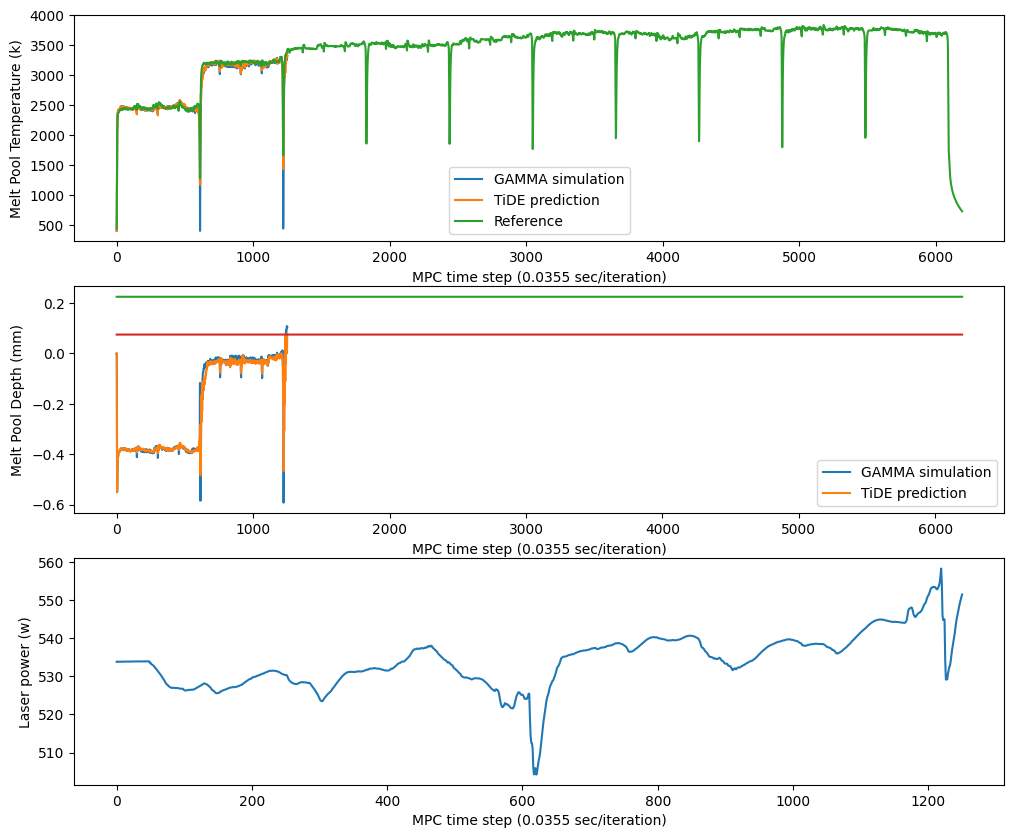

 29%|██▉       | 1800/6196 [16:20<1:12:36,  1.01it/s]

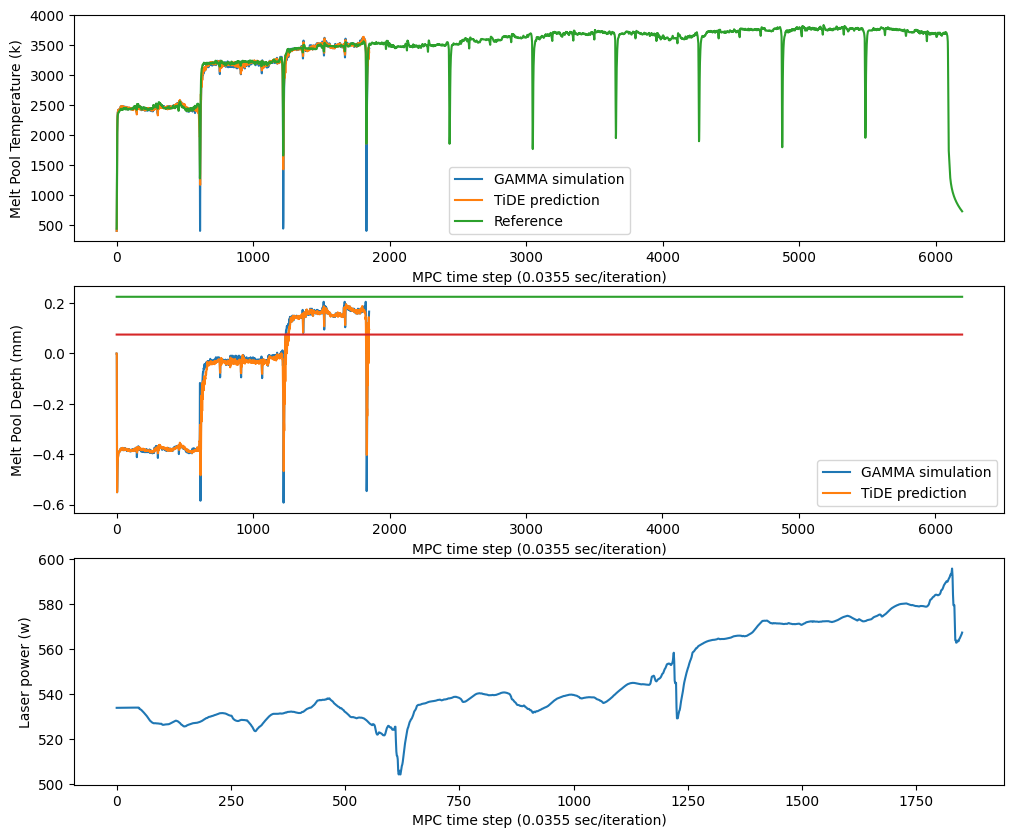

 39%|███▊      | 2400/6196 [23:25<42:47,  1.48it/s]  

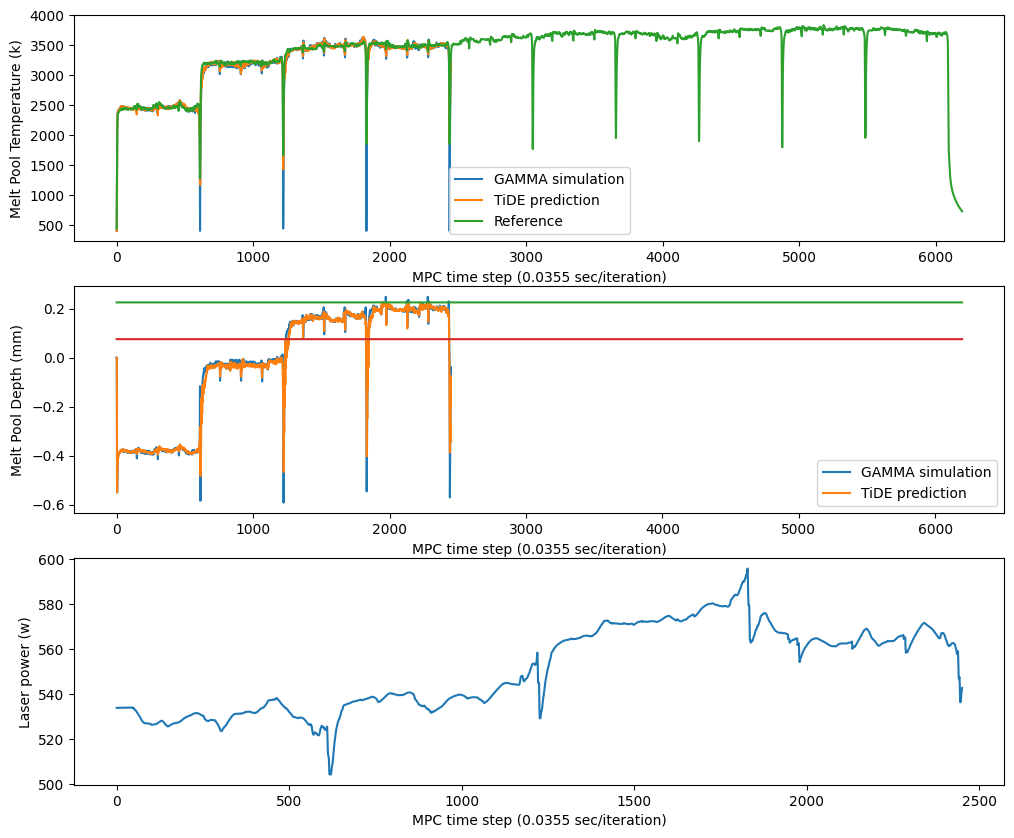

 48%|████▊     | 3000/6196 [29:55<31:15,  1.70it/s]

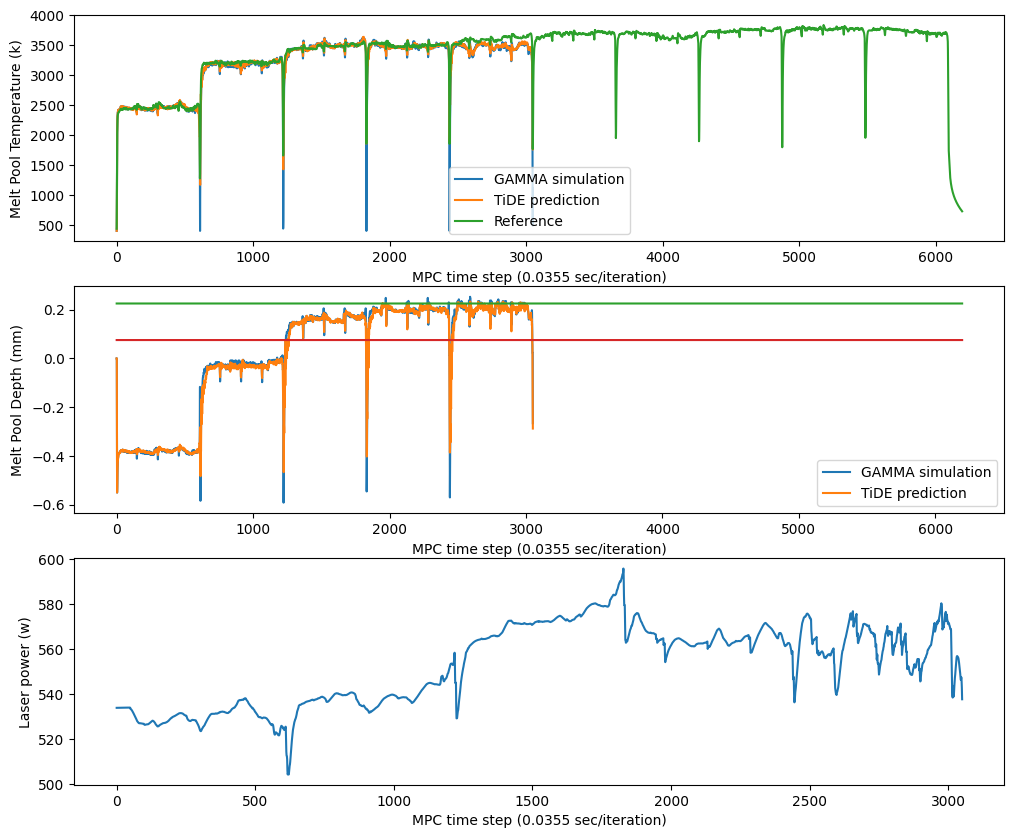

 58%|█████▊    | 3600/6196 [35:56<32:44,  1.32it/s]

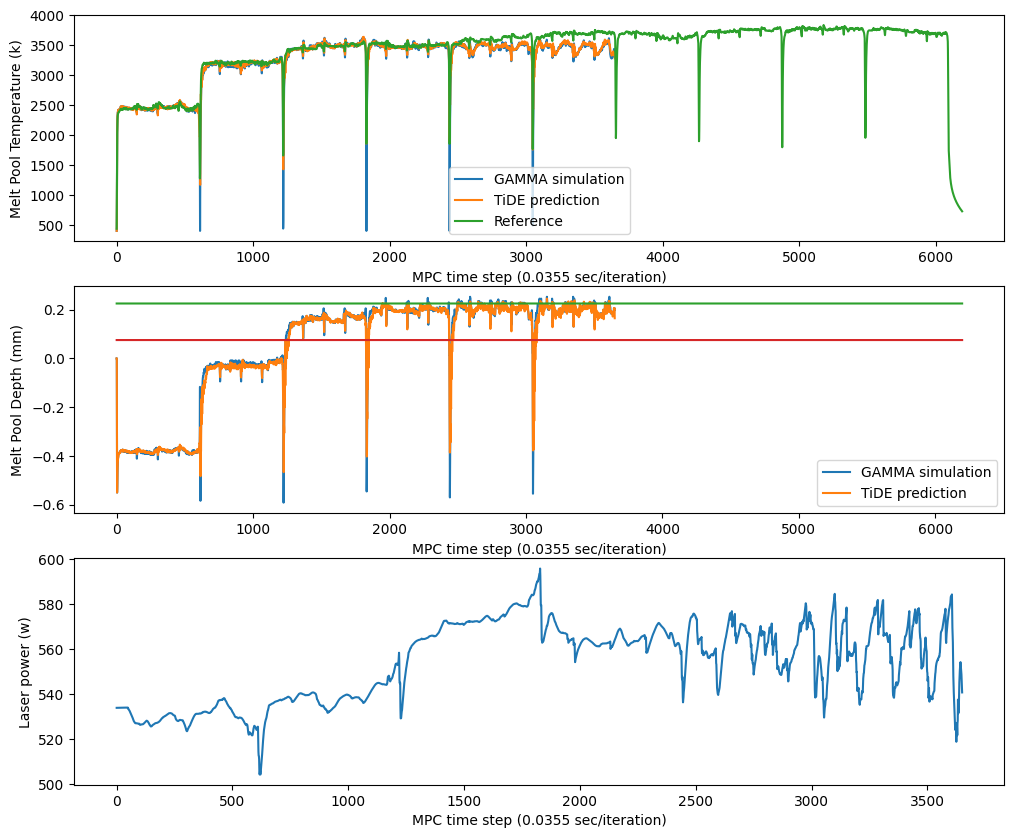

 68%|██████▊   | 4200/6196 [42:02<18:39,  1.78it/s]

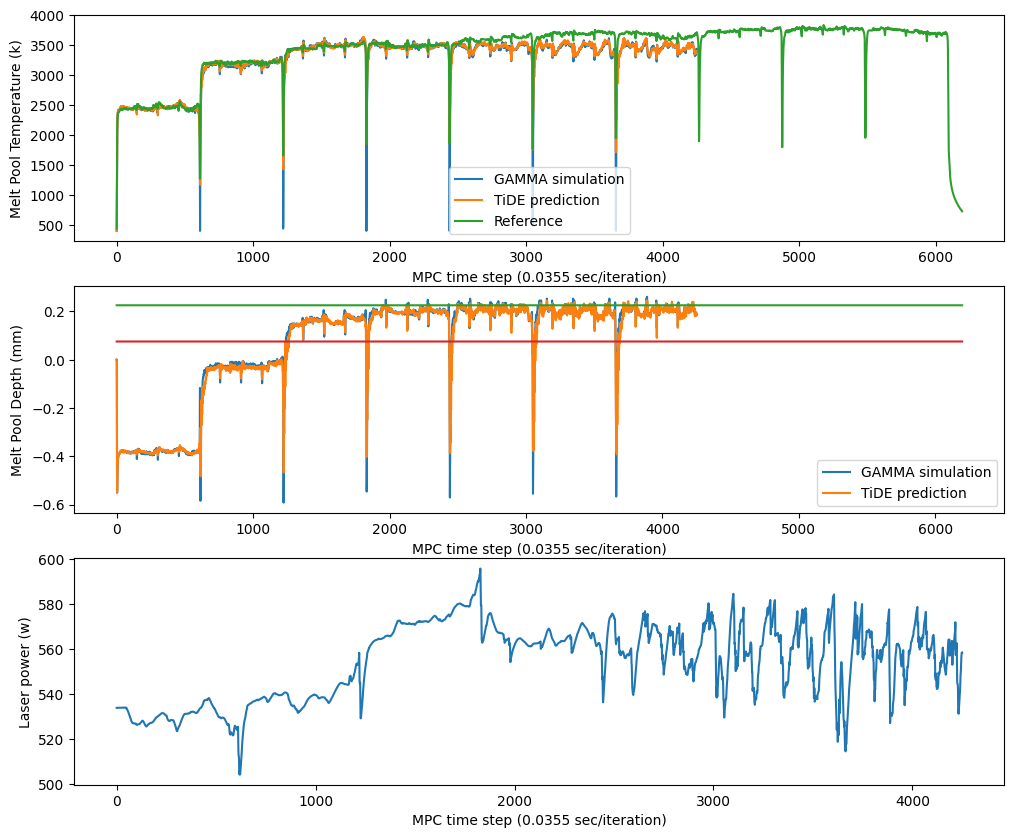

 77%|███████▋  | 4800/6196 [47:58<10:09,  2.29it/s]

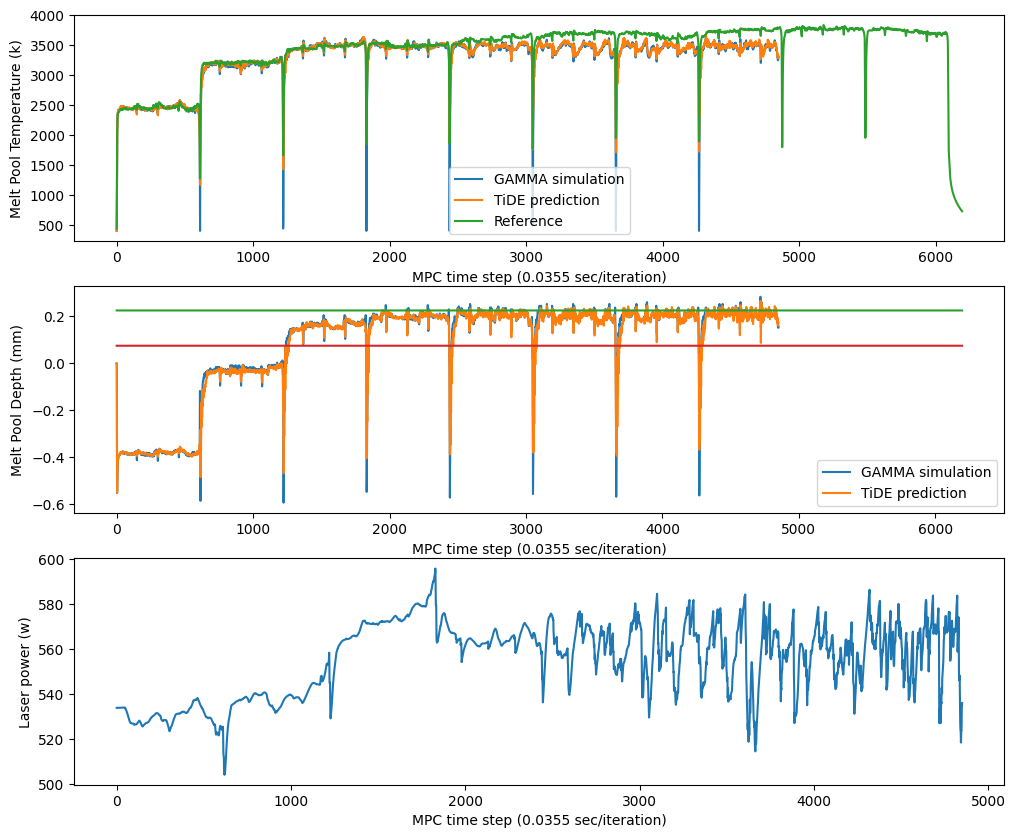

 87%|████████▋ | 5400/6196 [53:56<06:11,  2.14it/s]

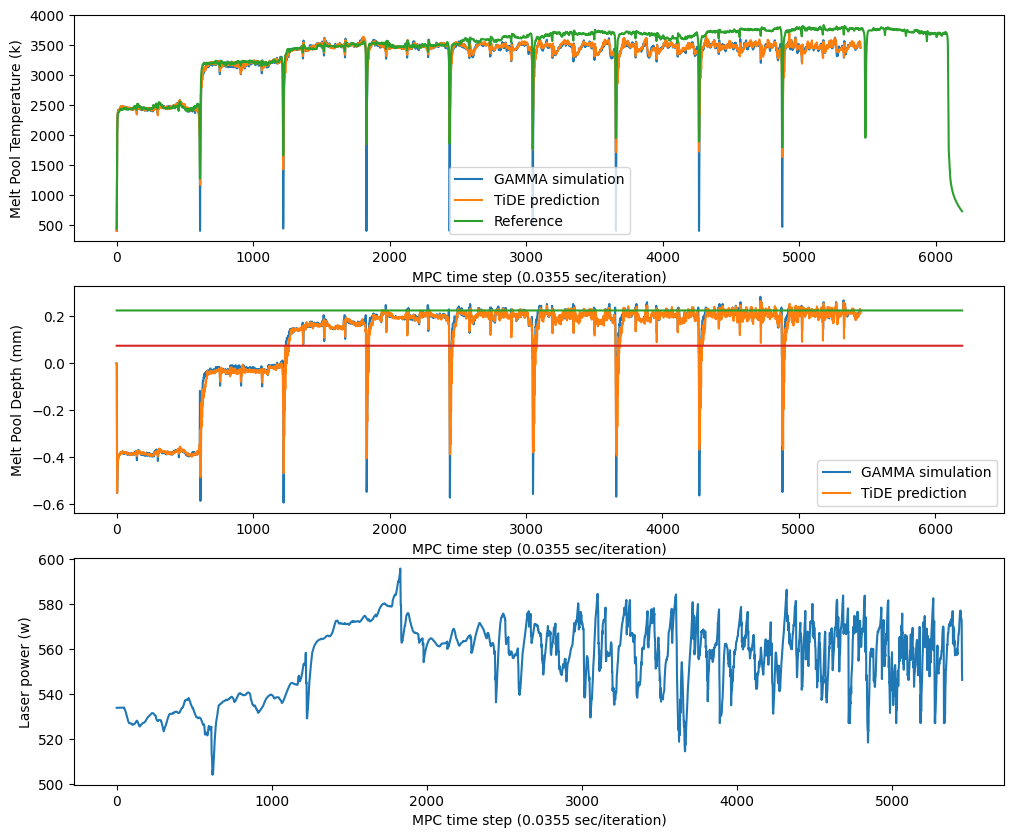

 97%|█████████▋| 6000/6196 [1:00:08<01:46,  1.84it/s]

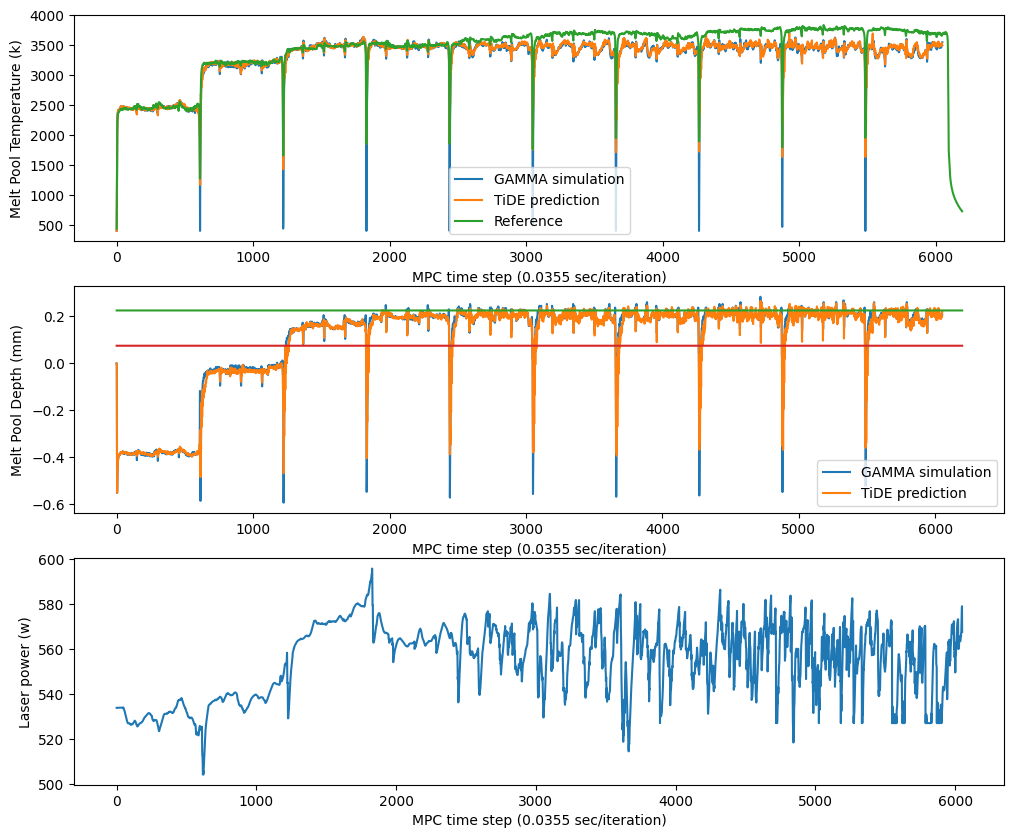

100%|██████████| 6196/6196 [1:01:30<00:00,  1.68it/s]


In [10]:
MPC_GAMMA = GAMMA_MPC(GAMMA_class, TiDE, RMPC_obj_w_constraint, mp_temp_ref, window, P, fix_covariates, init_avg, laser_power_past, LossParam, global_state)
#N_step = 6021 #6196
#N_step = 6196

N_step = 6196 - init_runs + 50

#RUN = "MPC"
RUN = "MPC"

if RUN == "MPC":
    for i in tqdm(range(N_step)):
        MPC_GAMMA.MPC_run_one_step_pytorch()
        if i % 600 == 0:
            plot_fig(MPC_GAMMA, N_step)

elif RUN == "PID":
    for i in tqdm(range(N_step)):
        MPC_GAMMA.PID_run_one_step()
        
else:
    print(f"No control method available")

In [11]:
aaaaa

NameError: name 'aaaaa' is not defined

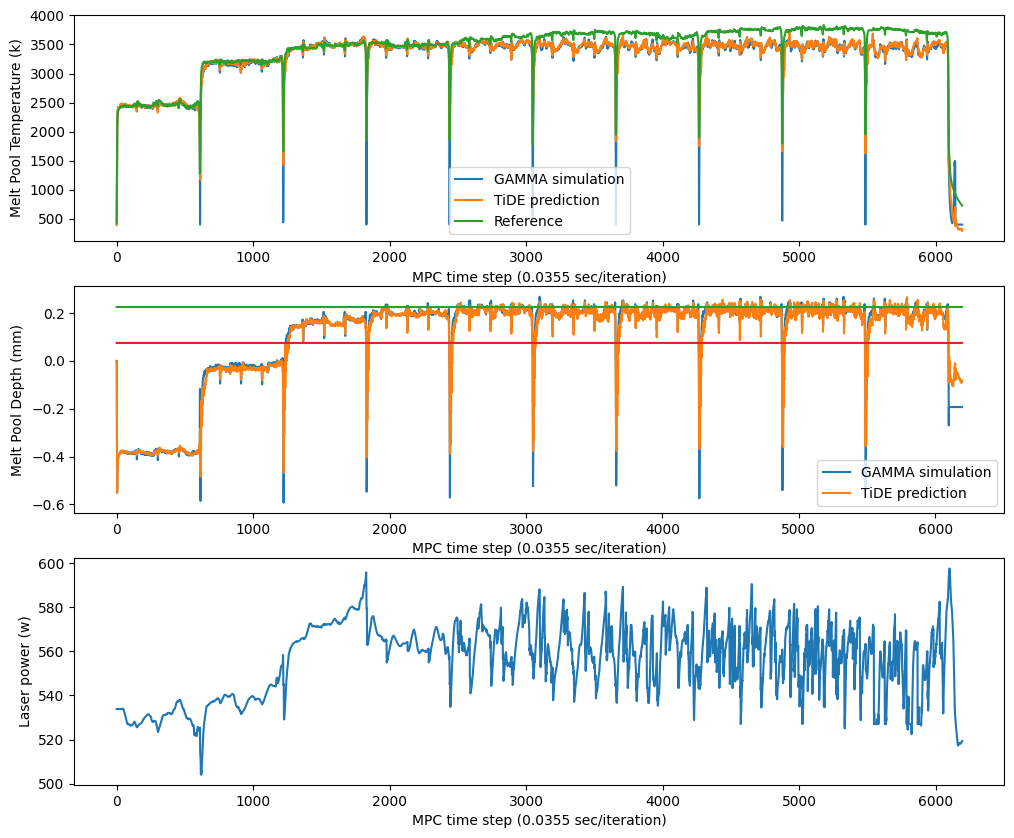

In [ ]:
N_step = 6196
plt.figure(figsize=[12,10])
plt.subplot(3,1,1)
plt.plot(MPC_GAMMA.x_past_save[:N_step,0], label = "GAMMA simulation")
plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,0], label="TiDE prediction")
plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
plt.legend()


plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.ylabel("Melt Pool Temperature (k)")

plt.subplot(3,1,2)
plt.plot(MPC_GAMMA.x_past_save[:N_step,1], label = "GAMMA simulation")
plt.plot(MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,1], label="TiDE prediction")
plt.plot(np.linspace(0,N_step,N_step),0.225*np.ones(N_step))
plt.plot(np.linspace(0,N_step,N_step),0.075*np.ones(N_step))
plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.ylabel("Melt Pool Depth (mm)")
plt.legend()

plt.subplot(3,1,3)
plt.plot(MPC_GAMMA.u_past_save[:N_step])
plt.ylabel("Laser power (w)")
plt.xlabel("MPC time step (0.0355 sec/iteration)")
plt.show()


0.25747192086828685

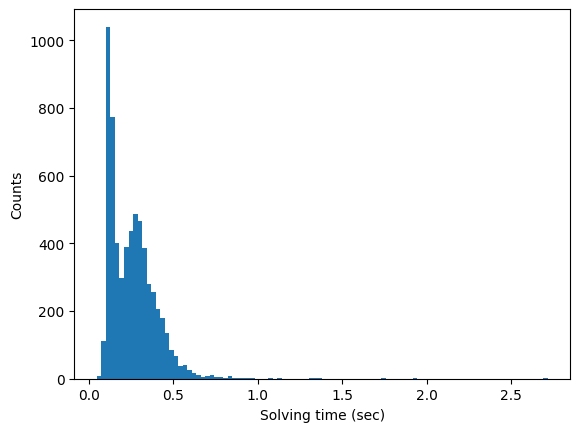

In [ ]:
time = np.array(MPC_GAMMA.save_time) * -1
plt.hist(time,100)
plt.xlabel("Solving time (sec)")
plt.ylabel("Counts")
np.mean(time)

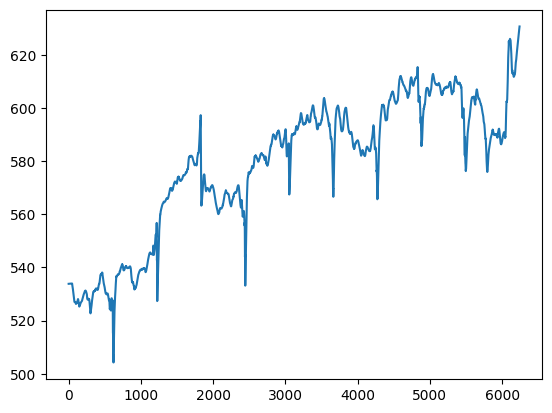

In [ ]:
plt.plot(MPC_GAMMA.u_past_save)

In [ ]:
aaaa

NameError: name 'aaaa' is not defined

In [ ]:
import pandas as pd
# Assuming the three variables are numpy arrays or lists
gamma_result_temp = MPC_GAMMA.x_past_save[:N_step,0].squeeze()
gamma_result_depth = MPC_GAMMA.x_past_save[:N_step,1].squeeze()
ref = MPC_GAMMA.ref[:N_step]
TiDE_pred_temp = MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,0]
TiDE_pred_depth = MPC_GAMMA.NN_pred_save.detach().numpy()[:N_step,1]
LP = MPC_GAMMA.u_past_save[:N_step].squeeze()

# Create a dictionary with the data
data = {
    'gamma_result_temp': gamma_result_temp,
    'gamma_result_depth': gamma_result_depth,
    'ref': ref,
    'TiDE_pred_temp': TiDE_pred_temp,
    'TiDE_pred_depth': TiDE_pred_depth,
    'Time': np.array(MPC_GAMMA.save_time) * -1,
    'LP': LP
}

# data = {
#     'gamma_result': gamma_result,
#     'ref': ref,
#     'LP': LP
# }

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('profile_1_MPC_w_depth_control_0925.csv', index=False)


#### Pytorch minimize w/o input bounds


In [ ]:
#  === Initial Conditions: Values at time = k ===============
k = 50


# temporary ref 
mp_temp_ref_part = mp_temp_ref[k:k+P] + torch.tensor(np.linspace(0,30,50),dtype=torch.float32)

mp_temp_ref_part_s = TiDE.scaler_y(mp_temp_ref_part)

# past melt pool temperature
mp_temp_past_part = mp_temp_ref[k-window:k]
mp_temp_past_part_s = TiDE.scaler_y(mp_temp_past_part).transpose(1,0)

# assume the past history is the same as the first term at the first step
fix_cov_past = fix_covariates[k-window:k,:]
fix_cov_past_s = TiDE.scaler_x(fix_cov_past,dim_id=[0,1,2])

# fix future covariate
fix_cov_future = fix_covariates[k:k+P,:]
fix_cov_future_s = TiDE.scaler_x(fix_cov_future,dim_id=[0,1,2])

# past laser power: take the given ones first
past_laser_power = laser_power_ref[k-window:k]
past_laser_power_s = TiDE.scaler_x(past_laser_power,dim_id=3)
future_laser_power = laser_power_ref[k:k+P]
future_laser_power_s = TiDE.scaler_x(future_laser_power,dim_id=3)

# designed laser power
u_hat = torch.zeros((P,1),dtype=torch.float32)
solution = pytorch_minimize(lambda u:RMPC_obj_wo_constraint(u,fix_cov_future_s,past_laser_power_s,fix_cov_past_s, mp_temp_past_part_s,mp_temp_ref_part_s,P,TiDE),torch.zeros((P,1)),method="l-bfgs")

mp_hat_opt_s = TiDE.forward(solution.x, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
mp_hat_opt = TiDE.inv_scaler_y(mp_hat_opt_s)
mp_real_s = TiDE.forward(future_laser_power_s, fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s) # predicted MP temp
mp_real = TiDE.inv_scaler_y(mp_real_s)
mp_hat_ini_guess_s = TiDE.forward(torch.ones((P,1)), fix_cov_future_s, past_laser_power_s, fix_cov_past_s, mp_temp_past_part_s)
mp_hat_ini_guess = TiDE.inv_scaler_y(mp_hat_ini_guess_s)

plt.plot(mp_hat_opt.squeeze().detach().numpy(), label="prediction via MPC")
plt.plot(mp_temp_ref_part.numpy(), label="ref")
plt.plot(mp_real.detach().numpy().T, label='prediction with future LP')
# plt.plot(mp_hat_ini_guess.detach().numpy().T, label="prediction with initial guess")
plt.legend()
#plt.ylim([2200,2400])
plt.show()

plt.figure()
plt.plot(TiDE.inv_scaler_x(solution.x.detach(),dim_id=3),label='opt')
plt.plot(TiDE.inv_scaler_x(future_laser_power_s,dim_id=3),label='true')
plt.legend()



RuntimeError: The size of tensor a (50) must match the size of tensor b (2) at non-singleton dimension 1